# Notebook Details
## This Notebook uses the Clustered file generated by previous notebook version KModes_clustering_by_featuregroups.ipynb 
(/data/SubClusters).

## The goals of this notebook are

#### 1. Analyze each subclusters
#### 2. Create patient profiles from the cluster population that helps to predict readmission of patients.



## Install Packages


In [ ]:
!pip install kmodes

## Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from itertools import combinations

from sklearn.metrics.cluster import adjusted_rand_score
from scipy.stats import mode
import warnings

from typing import Literal

# Suppress warnings
warnings.filterwarnings('ignore')

# User Defined Funtions

### create_sdoh_data_for_plot

In [ ]:
def create_sdoh_data_for_plot(data):
  # Define feature groups
  feature_groups = {
      'sdoh_pcp': ['sdoh_pcp_0.0', 'sdoh_pcp_1.0','sdoh_pcp_na'],
      'sdoh_ins': ['sdoh_ins_0.0', 'sdoh_ins_1.0','sdoh_ins_na'],
      'sdoh_housing2': ['sdoh_housing2_0.0', 'sdoh_housing2_1.0','sdoh_housing2_na'],
      'food_security': ['food_security_0.0', 'food_security_1.0','food_security_na'],
      'sdoh_util': ['sdoh_util_0.0', 'sdoh_util_1.0','sdoh_util_na'],
      'sdoh_trans': ['sdoh_trans_0.0', 'sdoh_trans_1.0','sdoh_trans_na'],
      'sdoh_employ': ['sdoh_employ_4.0','sdoh_employ_1.0','sdoh_employ_na'],
      'sdoh_dv': ['sdoh_dv_0.0','sdoh_dv_1.0','sdoh_dv_na'],
      'hiv_test_interest': ['hiv_test_interest_0.0','hiv_test_interest_1.0','hiv_test_interest_na'],
      'covid_vax_signup': ['covid_vax_signup_0.0','covid_vax_signup_1.0','covid_vax_signup_na'],
      'sdoh_diabetes': ['sdoh_diabetes_0.0','sdoh_diabetes_1.0','sdoh_diabetes_na'],
      'sdoh_asthma1': ['sdoh_asthma1_0.0','sdoh_asthma1_1.0','sdoh_asthma1_na'],
      'sdoh_alc': ['sdoh_alc_1.0', 'sdoh_alc_3.0', 'sdoh_alc_na'],
      'sdoh_substance': ['sdoh_substance_1.0', 'sdoh_substance_2.0','sdoh_substance_na'],
      'sdoh_emotional': ['sdoh_emotional_2.0','sdoh_emotional_1.0', 'sdoh_emotional_na'], # in case of emotional needs 1 = Yes and 2 = No
      'healthedneeds': ['healthedneeds_0.0', 'healthedneeds_1.0','healthedneeds_na'],
      'any_unmet_needs': ['any_unmet_needs_0.0', 'any_unmet_needs_1.0','any_unmet_needs_na']
    }
  # Initialize lists to store results for plotting
  group_names = []
  counts_0 = []
  counts_1 = []
  counts_na = []

  # Calculate counts for each feature group
  for group, features in feature_groups.items():
      # Count the occurrences of 1 for each feature
      counts = data[features].sum()

      # Add to lists
      group_names.append(group)
      counts_0.append(counts.get(features[0], 0))
      counts_1.append(counts.get(features[1], 0) if len(features) > 1 else 0)
      counts_na.append(counts.get(features[2], 0) if len(features) > 2 else 0)

  # Create a DataFrame for plotting
  plot_df = pd.DataFrame({
      'Feature Group': group_names,
      'Count_0': counts_0,
      'Count_1': counts_1,
      'Count_na': counts_na
  })

  # Sort the DataFrame by Total count in descending order
  plot_df = plot_df.sort_values(by='Count_1', ascending=False)

  # Reset index after sorting
  plot_df = plot_df.reset_index(drop=True)

  return plot_df

### create_comorbidity_data_for_plot

In [ ]:
def create_comorbidity_data_for_plot(data):
    # Define feature groups
    feature_groups = {
        'diabetes': ['diabetes_yes'],
        'hypertension': ['hypertension_yes'],
        'asthma': ['asthma_x_no', 'asthma_x_yes'],
        'SDoH_Diabetes': ['sdoh_diabetes_0.0', 'sdoh_diabetes_1.0', 'sdoh_diabetes_na'],
        'sdoh_asthma1': ['sdoh_asthma1_0.0', 'sdoh_asthma1_1.0', 'sdoh_asthma1_na'],
    }

    results = []
    for group_name, features in feature_groups.items():
        counts = data[features].apply(lambda x: x.sum()).reindex(features, fill_value=0)

        if group_name in ['diabetes','hypertension']:
          results.append({
            'Feature Group': group_name,
            'Count_0': len(data) - counts.get(features[0], 0),
            'Count_1': counts.get(features[0], 0),
            'Count_na': 0
          })
        else:
          results.append({
              'Feature Group': group_name,
              'Count_0': counts.get(features[0], 0),
              'Count_1': counts.get(features[1], 0) if len(features) > 1 else 0,
              'Count_na': counts.get(features[2], 0) if len(features) > 2 else 0
          })

    # Convert to DataFrame
    plot_df = pd.DataFrame(results)
    plot_df = plot_df.sort_values(by='Count_1', ascending=False).reset_index(drop=True)

    return plot_df

### plot_barchart

In [ ]:
def plot_barchart(dataframe, featureGroups: Literal['Comorbidity','SDoH'] = ''):
  """
  Plots a bar chart based on the provided dataframe.

  Parameters:
  dataframe: The data to be visualized.
  featureGroups (str): The type of features to plot, either 'Comorbidity' or 'SDoH'.

  Returns:
  None
  """

  # get the dataframe to plot barchart
  if featureGroups.lower() == 'comorbidity':
        plot_df = create_comorbidity_data_for_plot(dataframe)
  elif featureGroups.lower() == 'sdoh':
      plot_df = create_sdoh_data_for_plot(dataframe)
  else:
      raise ValueError("Invalid featureGroups value. Accepted values are 'Comorbidity' or 'SDoH'.")


  # Plotting
  fig, ax = plt.subplots(figsize=(14, 8))

  # Bar width and positions
  bar_width = 0.25
  index = np.arange(len(plot_df['Feature Group']))

  # Define pastel colors
  pastel_blue = '#aec6cf'
  pastel_orange = '#ffb347'
  pastel_green = '#77dd77'

  # Create bars for each count
  bar1 = ax.bar(index - bar_width, plot_df['Count_0'], bar_width, label='Count_0', color=pastel_blue)
  bar2 = ax.bar(index, plot_df['Count_1'], bar_width, label='Count_1', color=pastel_orange)
  bar3 = ax.bar(index + bar_width, plot_df['Count_na'], bar_width, label='Count_na', color=pastel_green)

  # Add counts on top of each bar
  for bars in [bar1, bar2, bar3]:
      for bar in bars:
          height = bar.get_height()
          ax.text(
              bar.get_x() + bar.get_width() / 2.0,
              height,
              f'{height:.0f}',
              ha='center',
              va='bottom'
          )

  # Adding labels and title
  ax.set_xlabel('Feature Group')
  ax.set_ylabel('Count')
  ax.set_xticks(index)
  ax.set_xticklabels(plot_df['Feature Group'], rotation=45, ha='right')

  # Custom legend text
  custom_labels = ['No', 'Yes','n/a']
  ax.legend(labels=custom_labels)

  plt.tight_layout()
  plt.show()

### plot_heatmap

In [ ]:
def plot_heatmap(dataframe, featureGroups: Literal['Comorbidity','SDoH'] = ''):
  """
  Plots a heatmap based on the provided dataframe.

  Parameters:
  dataframe: The data to be visualized.
  featureGroups (str): The type of features to plot, either 'Comorbidity' or 'SDoH'.

  Returns:
  None
  """

  # get the dataframe to plot barchart
  if featureGroups.lower() == 'comorbidity':
        plot_df = create_comorbidity_data_for_plot(dataframe)
  elif featureGroups.lower() == 'sdoh':
      plot_df = create_sdoh_data_for_plot(dataframe)
  else:
      raise ValueError("Invalid featureGroups value. Accepted values are 'Comorbidity' or 'SDoH'.")

  # Set 'Feature Group' as the index for the heatmap
  plot_df.set_index('Feature Group', inplace=True)

  # Plotting the heatmap with the custom colormap
  plt.figure(figsize=(6, 8))
  ax = sns.heatmap(plot_df, annot=True, fmt='d', cmap='YlGnBu', cbar=True, linewidths=.5)

  # Customizing the plot
  plt.title('Heatmap of Feature Counts')

  # Custom X-Tick Labels (make sure the length matches the number of columns in plot_df)
  custom_xtick_labels = ['No', 'Yes','n/a']  # Adjust based on plot_df's columns
  ax.set_xticklabels(custom_xtick_labels, rotation=45, ha='right')

  # Custom Y-Tick Rotation
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

  plt.tight_layout()

  # Display the plot
  plt.show()

# Cluster 2 Analysis of SDoH Questions

Dataset shape = (410, 100)




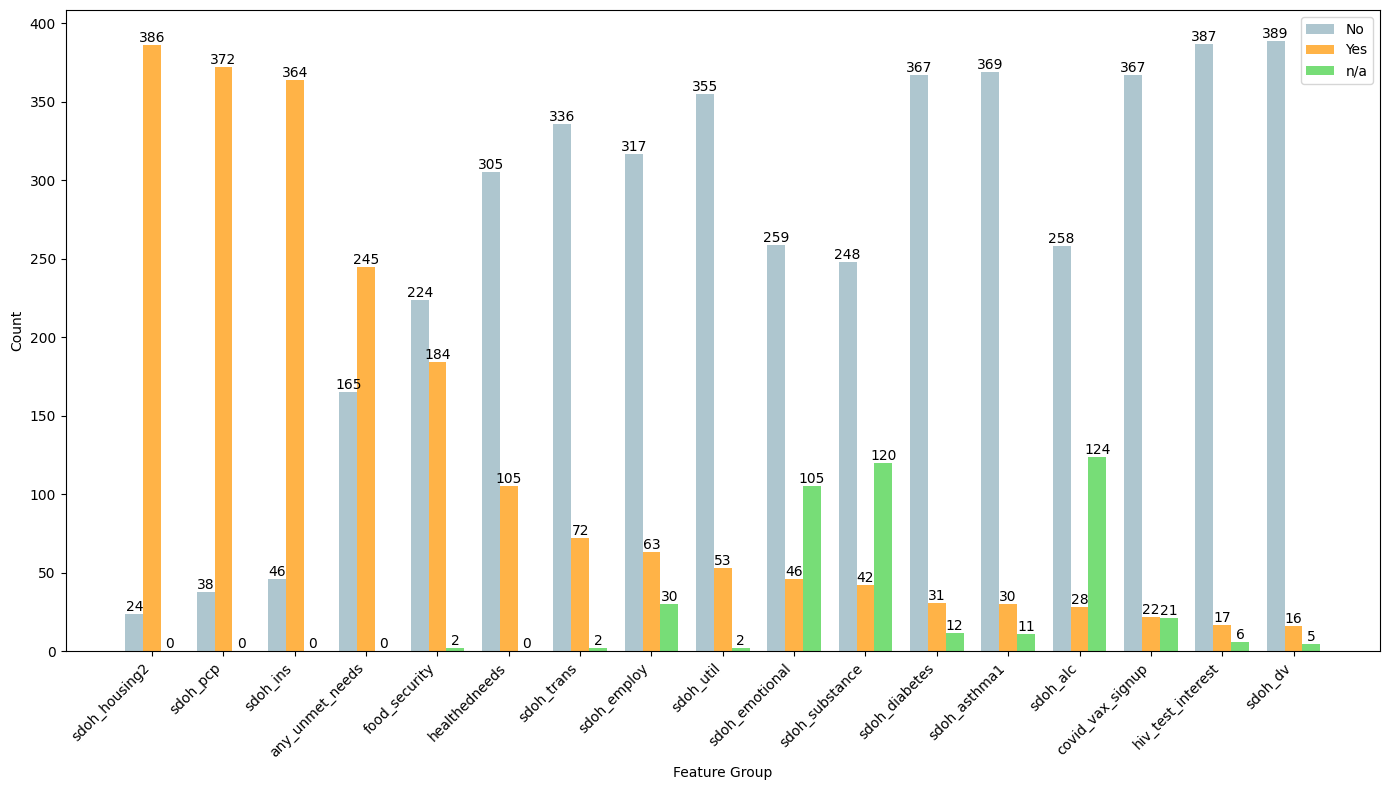

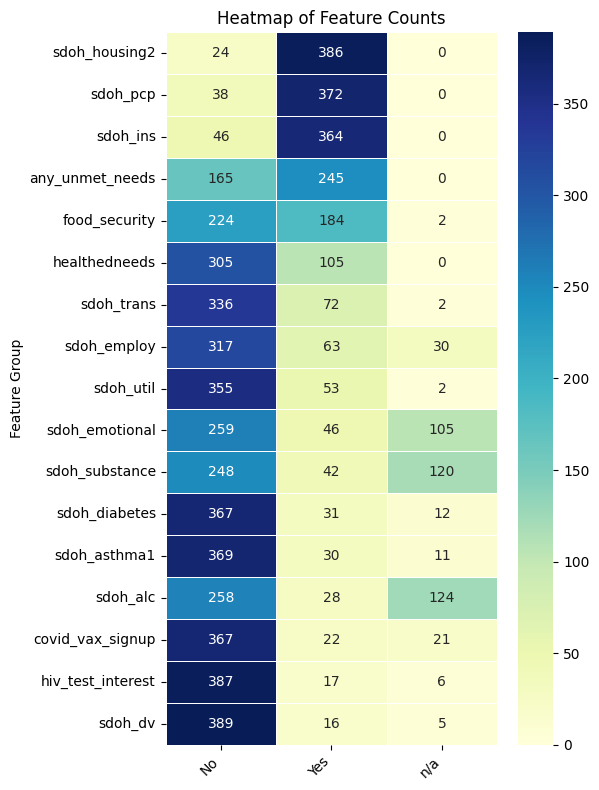

In [ ]:
path = '../results/SubClusters/Cluster_2_2024-08-21.csv'
cluster2_df = pd.read_csv(path)
print(f"Dataset shape = {cluster2_df.shape}")
print("\n")
plot_barchart(cluster2_df,featureGroups ='SDoH')
print("\n")
plot_heatmap(cluster2_df,featureGroups = 'SDoH')

# Cluster 0 Analysis of SDoH Questions

Dataset shape = (1033, 100)




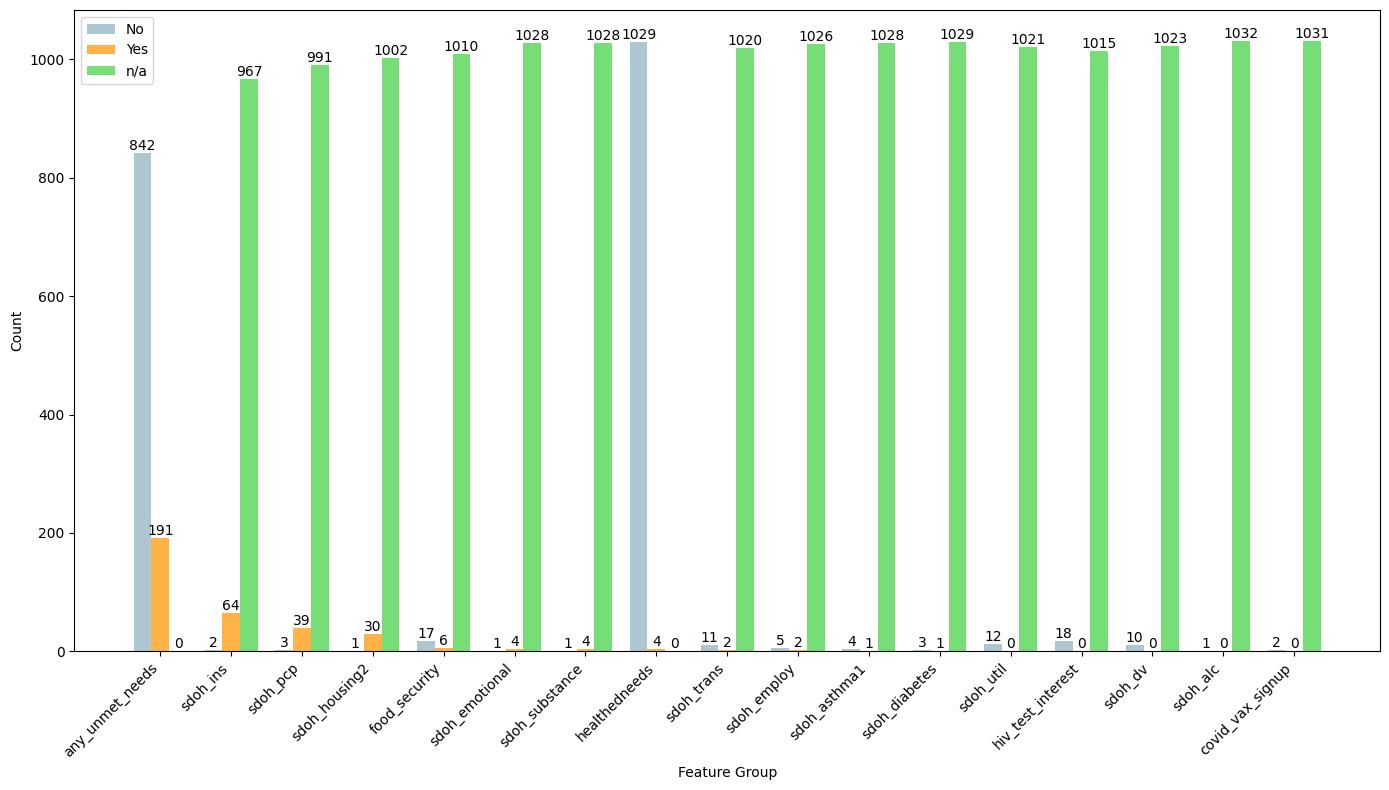

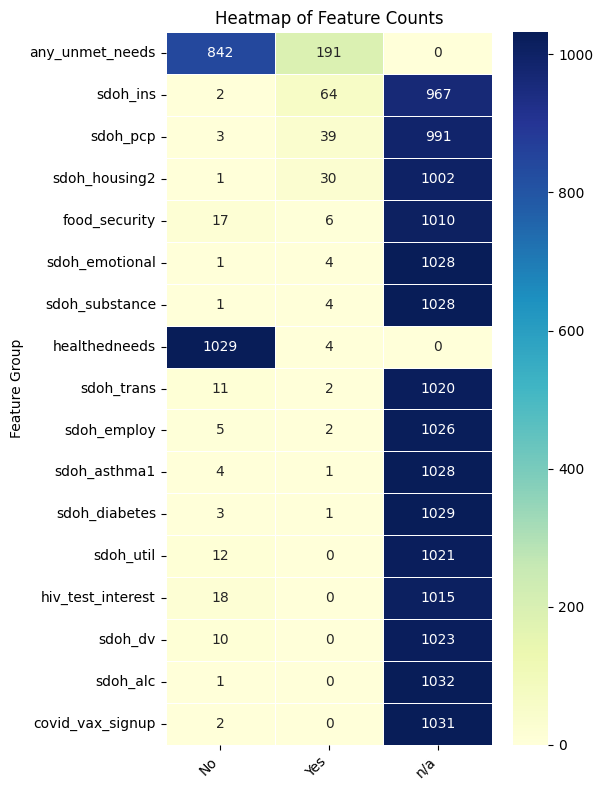

In [ ]:
path = '../results/SubClusters/Cluster_0_2024-08-21.csv'
cluster0_df = pd.read_csv(path)
print(f"Dataset shape = {cluster0_df.shape}")
print("\n")
plot_barchart(cluster0_df,featureGroups = 'SDoH')
print("\n")
plot_heatmap(cluster0_df,featureGroups = 'SDoH')

# Cluster 1 Analysis of Comorbidities

Dataset shape = (730, 100)
Plot SDoH Features



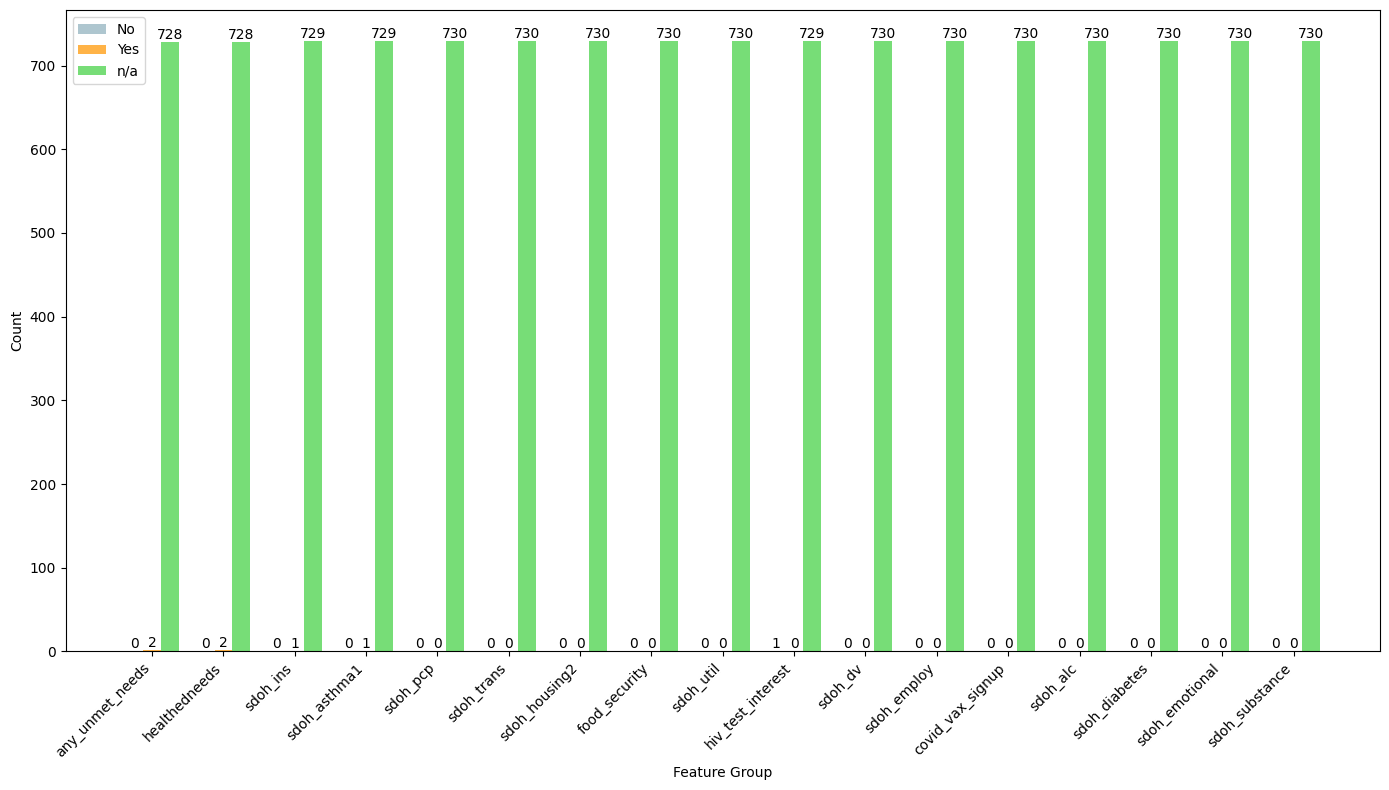

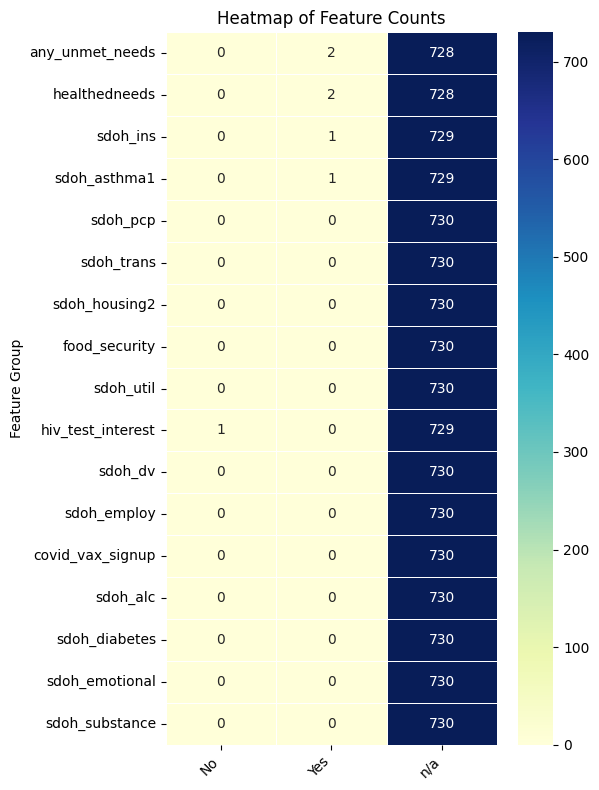


 Plot Comorbidity Features



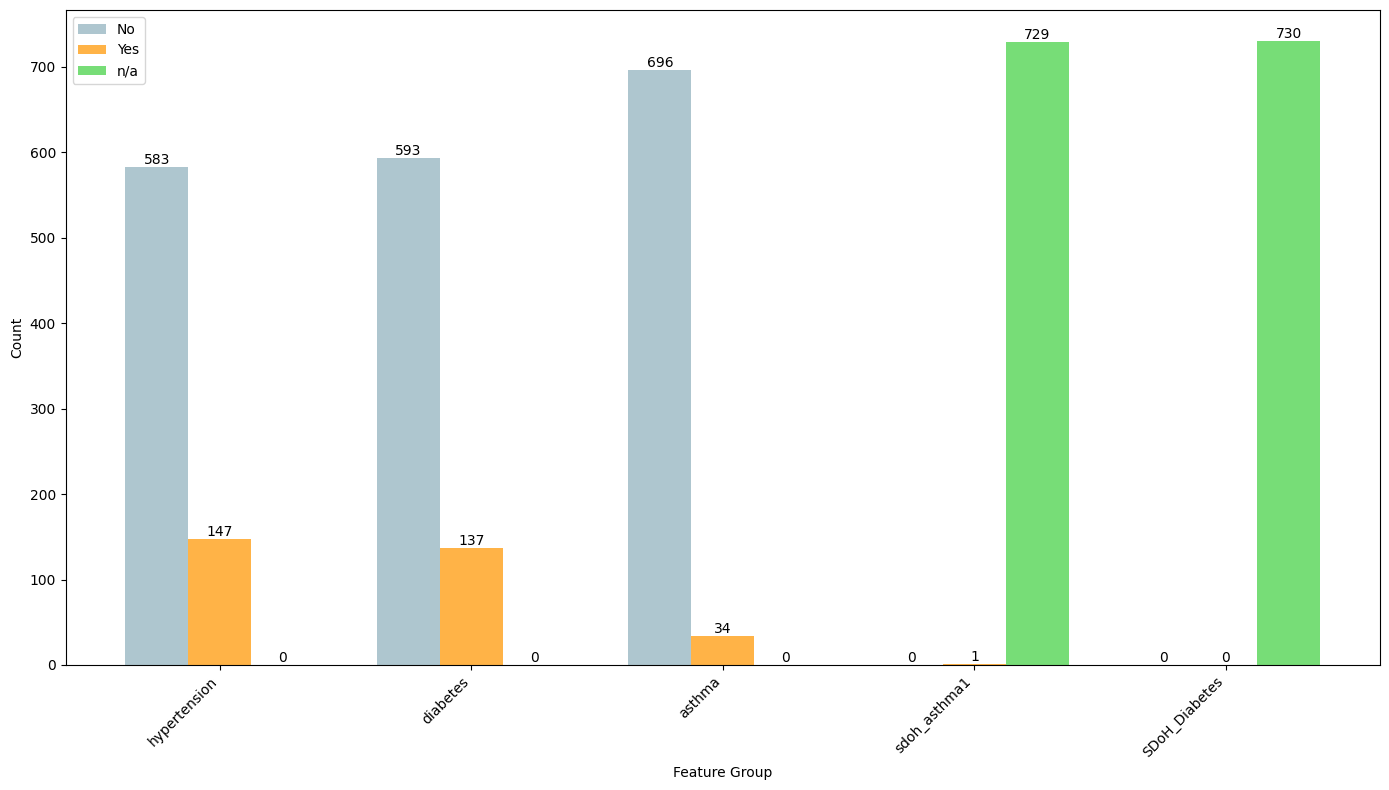

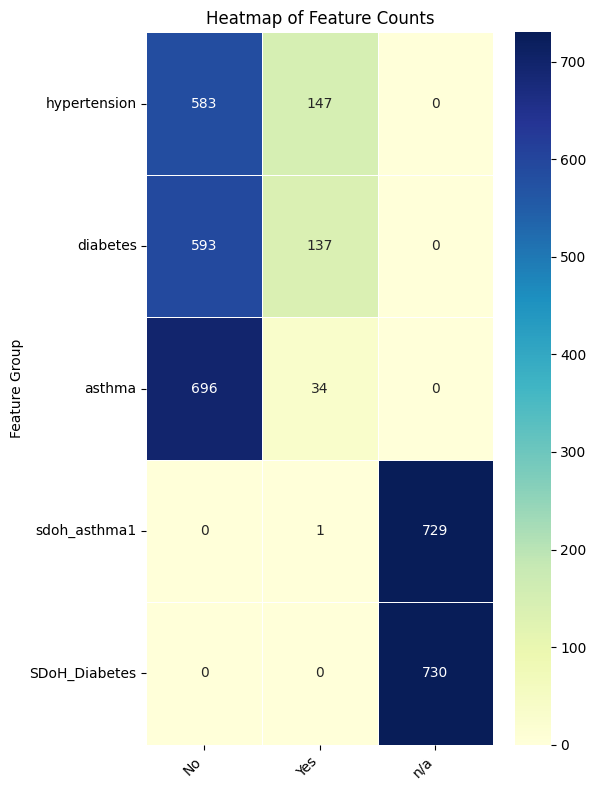

In [ ]:
path = '../results/SubClusters/Cluster_1_2024-08-21.csv'
cluster1_df = pd.read_csv(path)

print(f"Dataset shape = {cluster1_df.shape}")

print("Plot SDoH Features\n")
plot_barchart(cluster1_df,featureGroups = 'SDoH')
print("\n")
plot_heatmap(cluster1_df,featureGroups = 'SDoH')
print("\n Plot Comorbidity Features\n")
plot_barchart(cluster1_df,featureGroups = 'Comorbidity')
print("\n")
plot_heatmap(cluster1_df,featureGroups = 'Comorbidity')

# Diabetes Patients Analysis

In [ ]:
path = '../results/csv/SUHI_Matrix_Clustered2024-08-13.csv'
clustered_df = pd.read_csv(path)

print(f"Dataset shape = {clustered_df.shape}")

diabetes_df = clustered_df[clustered_df['diabetes_yes'] == 1]

print(f'Total diabetes patients = {diabetes_df.shape[0]}')
#print(f'Total readmitted patients = {diabetes_df['day_readmit'] == 1}')

diabetes_surveyed_df = diabetes_df[diabetes_df['sdoh_yesno_1.0'] == 1]
print(f'Total diabetes surveyed patients = {diabetes_surveyed_df.shape[0]}\n')

plot_barchart(diabetes_surveyed_df,featureGroups = 'SDoH')

print("\n")

plot_heatmap(diabetes_surveyed_df,featureGroups = 'SDoH')

SyntaxError: f-string: unmatched '[' (<ipython-input-10-1f9cc99d7f6a>, line 9)

# Hypertension Patients Analysis

Dataset shape = (2173, 99)
Total Hypertension patients = 658
Total Hypertension surveyed patients = 351



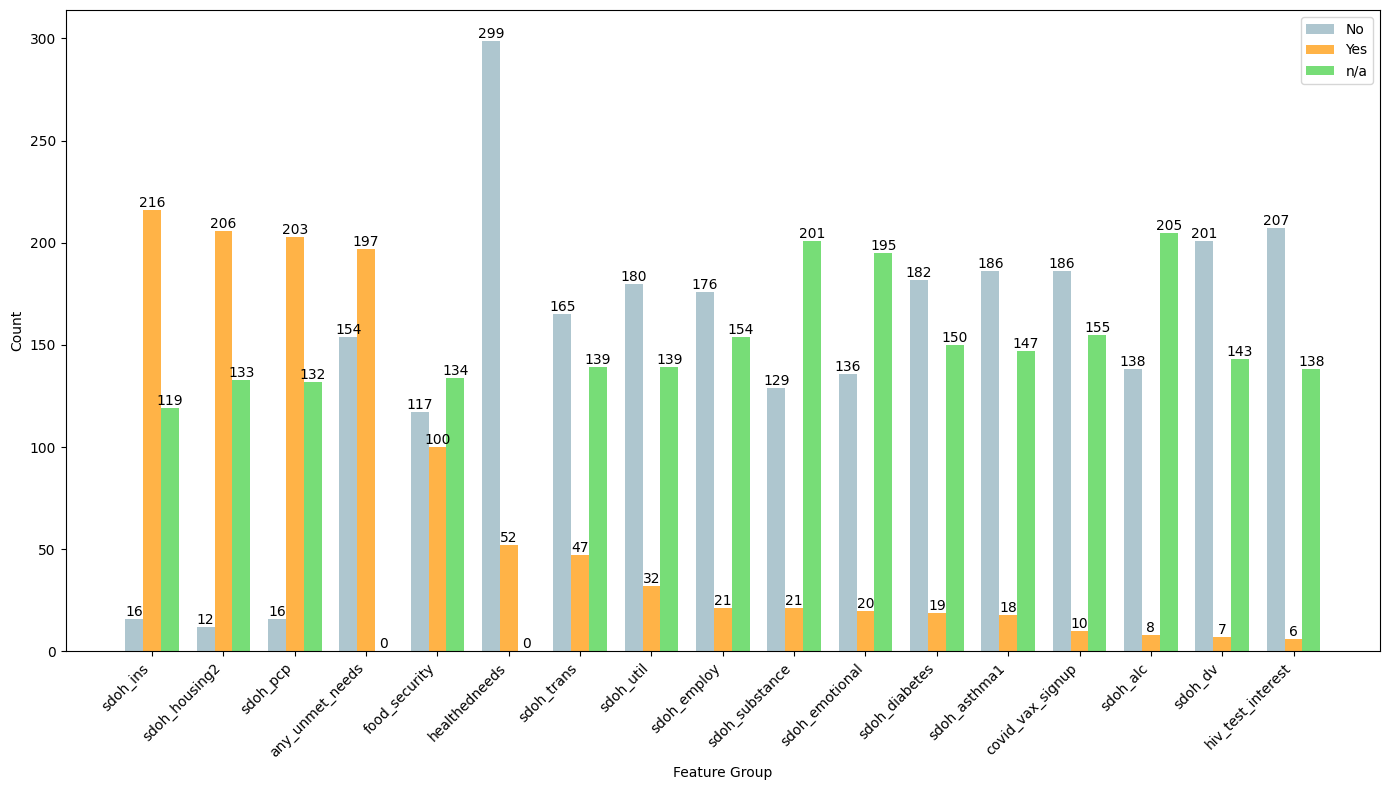

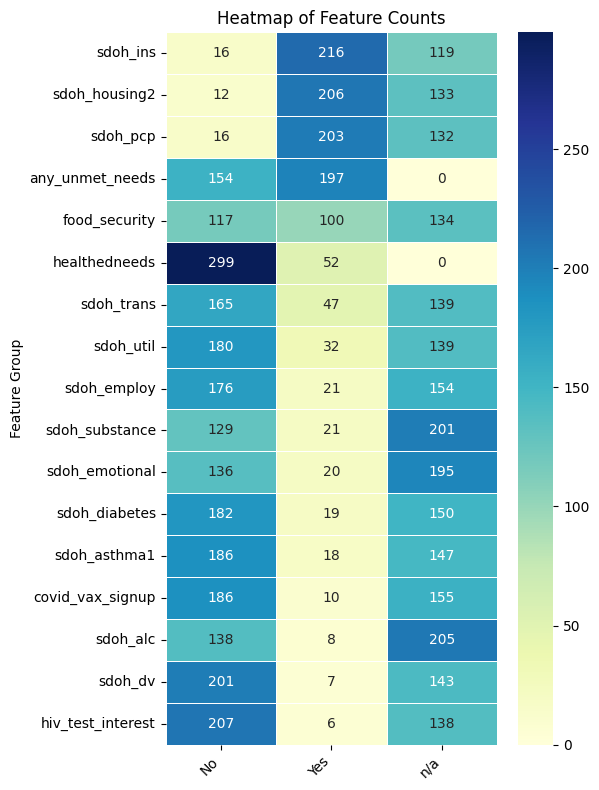

In [ ]:
path = '../results/csv/SUHI_Matrix_Clustered2024-08-13.csv'
clustered_df = pd.read_csv(path)
print(f"Dataset shape = {clustered_df.shape}")

hypertension_df = clustered_df[clustered_df['hypertension_yes'] == 1]

print(f'Total Hypertension patients = {hypertension_df.shape[0]}')

hypertension_surveyed_df = hypertension_df[hypertension_df['sdoh_yesno_1.0'] == 1]
print(f'Total Hypertension surveyed patients = {hypertension_surveyed_df.shape[0]}\n')

plot_barchart(hypertension_surveyed_df,featureGroups = 'SDoH')

print("\n")

plot_heatmap(hypertension_surveyed_df,featureGroups = 'SDoH')

# Asthma patients analysis

Dataset shape = (2173, 99)
Total Asthma patients = 161
Total Asthma surveyed patients = 78



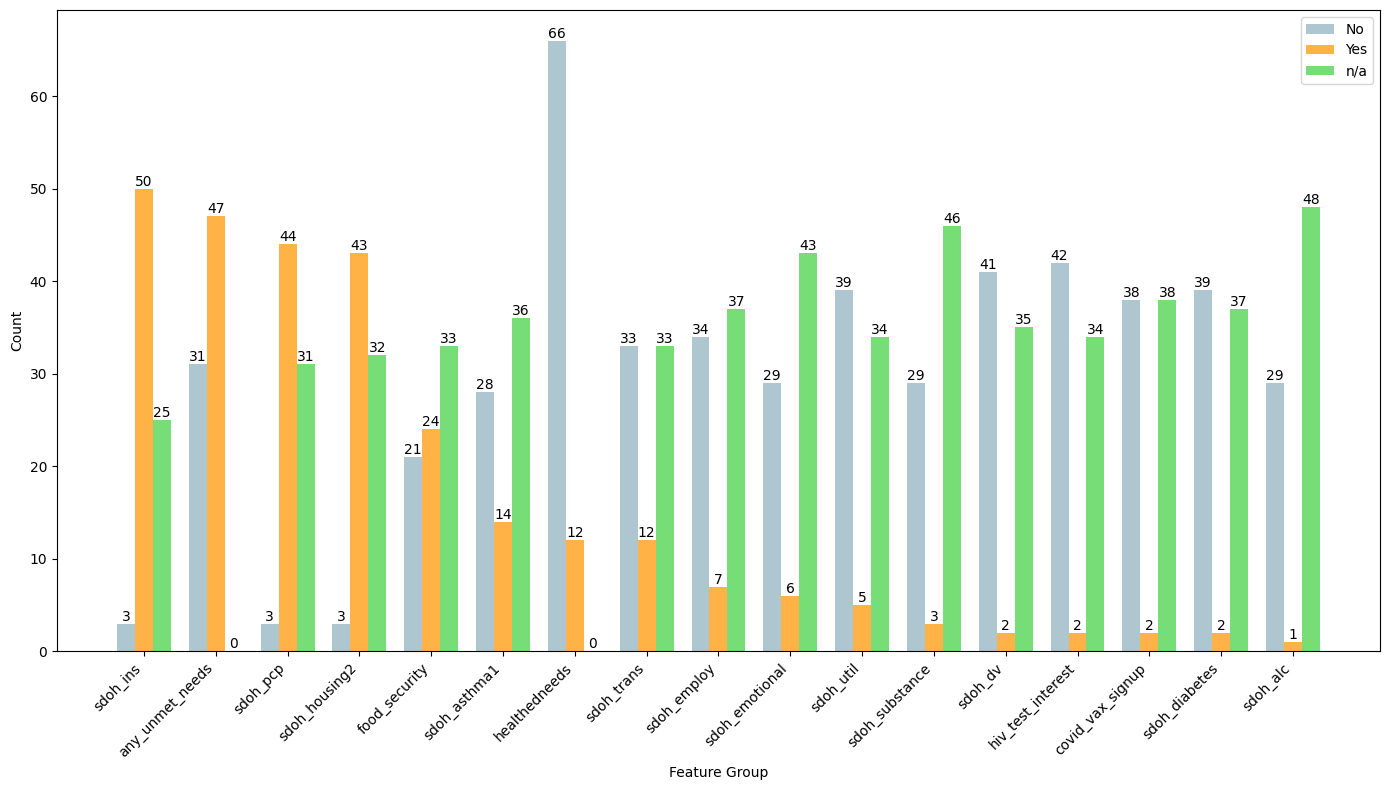

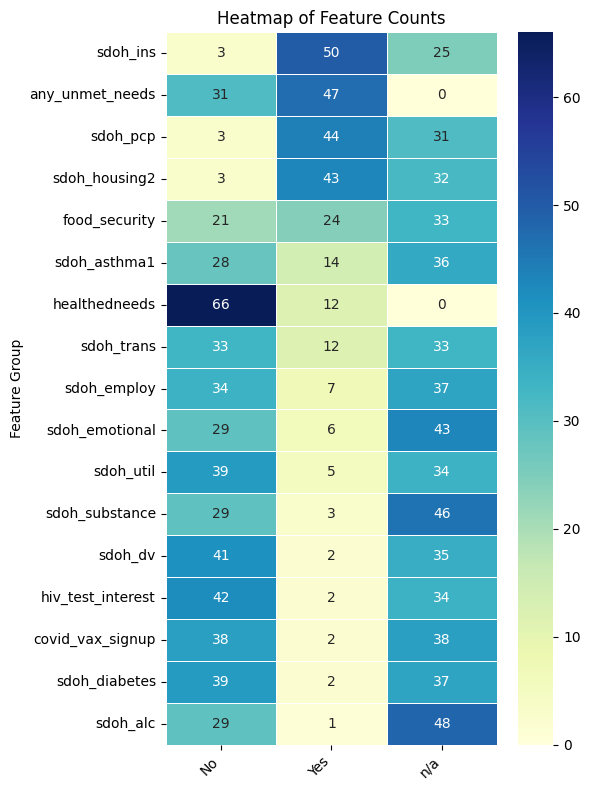

In [ ]:
path = '../results/csv/SUHI_Matrix_Clustered2024-08-13.csv'
clustered_df = pd.read_csv(path)
print(f"Dataset shape = {clustered_df.shape}")

asthma_df = clustered_df[clustered_df['asthma_x_yes'] == 1]

print(f'Total Asthma patients = {asthma_df.shape[0]}')

asthma_surveyed_df = asthma_df[asthma_df['sdoh_yesno_1.0'] == 1]
print(f'Total Asthma surveyed patients = {asthma_surveyed_df.shape[0]}\n')

plot_barchart(asthma_surveyed_df,featureGroups = 'SDoH')

print("\n")

plot_heatmap(asthma_surveyed_df,featureGroups = 'SDoH')